<Axes: >

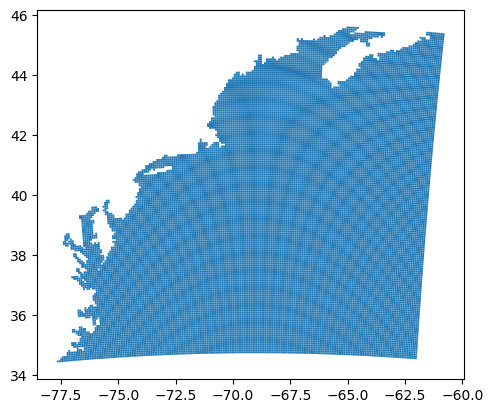

In [15]:
import geopandas as gpd

fid = '7km/clipped_NE_grid_7km_reprojected.shp'

gdf_grid = gpd.read_file(fid)

# print(gdf_grid.head())
gdf_grid.plot()

# Get Data From Various Sources

Aggregating Study Fleet, eMOLT, and CFRF data into a single dataframe

## Study Fleet

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

study_fleet = pd.read_csv('data/local_data/SF_7KM_BottomTempData_AllData.csv')
study_fleet['OBSERVATION_DATE'] = pd.to_datetime(study_fleet['OBSERVATION_DATE'])
study_fleet.rename(columns={'OBSERVATION_DATE': 'time', 'GRID_ID': 'id','TEMP':'temperature'}, inplace=True)

fid = '7km/clipped_NE_grid_7km_reprojected.shp'
gdf_grid = gpd.read_file(fid)
projected_crs = "EPSG:5070"  # Albers Equal Area Conic
# projected_crs = "EPSG:4326"  # WSG84. Cannot use to find grid centroids
gdf_grid = gdf_grid.to_crs(projected_crs)
gdf_grid['centroid'] = gdf_grid.geometry.centroid
gdf_grid['centroid'] = gdf_grid['centroid'].to_crs("EPSG:4326")
gdf_grid['geometry'] = gdf_grid['geometry'].to_crs("EPSG:4326")
gdf_grid['id'] = gdf_grid['id'].astype(int)
gdf_grid
study_fleet = study_fleet.merge(gdf_grid[['id','geometry', 'centroid']], on='id', how='left')
study_fleet['data_source'] = 'StudyFleet'
study_fleet

/tmp/ipykernel_59532/3825575828.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  study_fleet['OBSERVATION_DATE'] = pd.to_datetime(study_fleet['OBSERVATION_DATE'])


,time,temperature,id,geometry,centroid,data_source
0,2012-11-02,16.2,15038,"POLYGON ((-71.58332 41.05842, -71.50009 41.060...",POINT (-71.54049 41.02785),StudyFleet
1,2012-11-02,16.0,15038,"POLYGON ((-71.58332 41.05842, -71.50009 41.060...",POINT (-71.54049 41.02785),StudyFleet
2,2012-11-02,16.0,15038,"POLYGON ((-71.58332 41.05842, -71.50009 41.060...",POINT (-71.54049 41.02785),StudyFleet
3,2012-11-02,16.2,15038,"POLYGON ((-71.58332 41.05842, -71.50009 41.060...",POINT (-71.54049 41.02785),StudyFleet
4,2012-11-02,16.2,15038,"POLYGON ((-71.58332 41.05842, -71.50009 41.060...",POINT (-71.54049 41.02785),StudyFleet
...,...,...,...,...,...,...
5271828,2006-10-16,8.6,22131,"POLYGON ((-68.1327 43.66883, -68.04588 43.6681...",POINT (-68.08977 43.63699),StudyFleet
5271829,2006-10-16,8.6,22131,"POLYGON ((-68.1327 43.66883, -68.04588 43.6681...",POINT (-68.08977 43.63699),StudyFleet
5271830,2006-10-16,8.6,22131,"POLYGON ((-68.1327 43.66883, -68.04588 43.6681...",POINT (-68.08977 43.63699),StudyFleet
5271831,2006-10-16,8.6,22131,"POLYGON ((-68.1327 43.66883, -68.04588 43.6681...",POINT (-68.08977 43.63699),StudyFleet


In [57]:
import pandas as pd
from erddapy import ERDDAP

def get_emolt_data(start_time, end_time):
    """
    Fetch data from the eMOLT ERDDAP server.

    Parameters:
    start_time (str): The start time in ISO 8601 format (e.g., '2023-01-01T00:00:00Z').
    end_time (str): The end time in ISO 8601 format (e.g., '2023-12-31T23:59:59Z').
    latitude_range (tuple): A tuple containing the minimum and maximum latitude (e.g., (41, 42)).
    longitude_range (tuple): A tuple containing the minimum and maximum longitude (e.g., (-72, -70)).

    Returns:
    pd.DataFrame: A pandas DataFrame containing the fetched data.
    """
    server = 'https://comet.nefsc.noaa.gov/erddap/'
    e = ERDDAP(
        server=server,
        protocol="tabledap",
        response="csv",
    )
    e.dataset_id = 'eMOLT_realtime_bottom_temps_and_profiles'
    e.constraints = {
        'time>=': start_time,
        'time<=': end_time,
        'segment_type=': 'Fishing',
        # 'latitude<=': latitude_range[1],
        # 'longitude>=': longitude_range[0],
        # 'longitude<=': longitude_range[1]
    }
    e.variables = [
        'time', 'latitude', 'longitude', 'temperature', 'depth'
    ]

    df = e.to_pandas()
    return df

# Example usage
start_time = '2000-01-01T00:00:00Z'
end_time = '2025-03-20T00:00:00Z'


emolt_data = get_emolt_data(start_time, end_time)
print(emolt_data.head())

             time (UTC)  latitude (degrees_north)  longitude (degrees_east)  \
0  2023-08-12T11:12:22Z                   44.0111                  -68.2197   
1  2023-08-12T11:17:22Z                   44.0111                  -68.2197   
2  2023-08-12T11:22:22Z                   44.0111                  -68.2197   
3  2023-08-12T11:27:22Z                   44.0111                  -68.2197   
4  2023-08-12T11:32:22Z                   44.0111                  -68.2197   

   temperature (degree_C)  depth (m)  
0                   9.544       97.4  
1                   9.539       97.5  
2                   9.527       97.6  
3                   9.515       97.6  
4                   9.501       97.7  


## eMOLT

In [ ]:
# Get the eMOLT real time temp data
import xarray as xr
data = xr.open_dataset('data/local_data/eMOLT_RT_FULL.nc')
emolt = data.to_dataframe()
emolt['time'] = pd.to_datetime(emolt['time'])
keepers = ['time', 'latitude', 'longitude', 'temperature','tow_id']
emolt = emolt[keepers]
emolt = emolt.groupby('tow_id', group_keys=False).apply(lambda x: x.set_index('time').resample('h').mean()).reset_index()


keepers = ['time', 'latitude', 'longitude', 'temperature']
emolt.reset_index(inplace=True)
emolt = emolt[keepers]
emolt['data_source'] = 'eMOLT'

# get eMOLT DO 
import xarray as xr
import pandas as pd

data = xr.open_dataset('data/local_data/eMOLT_RT_LOWELL_DO.nc')
emolt_do = data.to_dataframe()
emolt_do['time'] = pd.to_datetime(emolt_do['time'])
# keepers = ['time', 'latitude', 'longitude', 'temperature']
emolt_do.reset_index(inplace=True)
keepers = ['time', 'latitude', 'longitude','temperature', 'DO','water_detect_perc','tow_id']
emolt_do = emolt_do[keepers]
# emolt_do['data_source'] = 'eMOLT'
emolt_do = emolt_do[emolt_do['water_detect_perc'] > 60]
emolt_do = emolt_do[emolt_do['DO'] > 0]
emolt_do = emolt_do[(emolt_do['temperature'] > 0) & (emolt_do['temperature'] < 27)] # gross range test 
# Remove records where the length of tow_id is less than 10

emolt_do['flag'] = emolt_do.groupby('tow_id')['DO'].transform(lambda x: (x - x.mean()).abs() > 3 * x.std())
emolt_do = emolt_do[emolt_do['flag'] == False]

emolt_do['DO_filtered'] = emolt_do.groupby('tow_id')['DO'].transform(lambda x: medfilt(x, kernel_size=5))
# emolt_do = emolt_do[emolt_do['tow_id'].astype(str).str.len() >= 10] # find short tow_ids
emolt_do = emolt_do.groupby('tow_id', group_keys=False).apply(lambda x: x.set_index('time').resample('h').mean()).reset_index()

keepers = ['time', 'latitude', 'longitude','temperature', 'DO_filtered']
emolt_do = emolt_do[keepers]
emolt_do.rename(columns={'DO_filtered': 'dissolved_oxygen'}, inplace=True)
emolt_do = emolt_do[emolt_do['dissolved_oxygen'] > 0]

emolt_do['data_source'] = 'eMOLT'

emolt = pd.concat([emolt, emolt_do], ignore_index=True).reset_index().drop(columns='index')
emolt

/tmp/ipykernel_59532/3660281173.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  emolt = emolt.groupby('tow_id', group_keys=False).apply(lambda x: x.set_index('time').resample('h').mean()).reset_index()
/tmp/ipykernel_59532/3660281173.py:36: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  emolt_do['DO_filtered'] = emolt_do.groupby('tow_id')['DO'].transform(lambda x: medfilt(x, kernel_size=5))
/tmp/ipykernel_59532/3660281173.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` 

,time,latitude,longitude,temperature,data_source,dissolved_oxygen
0,2023-08-12 11:00:00,44.011101,-68.219704,9.416100,eMOLT,NaN
1,2023-08-12 12:00:00,44.011097,-68.219704,9.043834,eMOLT,NaN
2,2023-08-12 13:00:00,44.011097,-68.219704,9.078166,eMOLT,NaN
3,2023-08-12 14:00:00,44.011097,-68.219704,9.066333,eMOLT,NaN
4,2023-08-12 15:00:00,44.011097,-68.219704,9.068000,eMOLT,NaN
...,...,...,...,...,...,...
558243,2024-12-10 04:00:00,41.936001,-70.371902,9.582500,eMOLT,10.697500
558244,2024-12-10 05:00:00,41.936001,-70.371902,9.502500,eMOLT,10.712500
558245,2024-12-10 06:00:00,41.936001,-70.371902,9.466666,eMOLT,10.720000
558246,2024-12-10 07:00:00,41.936001,-70.371902,9.430000,eMOLT,10.720000


In [3]:
import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

from erddapy import ERDDAP
def truncate_at_first_space(col_name):
    return col_name.split(' ')[0]
server = 'https://erddap.ondeckdata.com/erddap/'
e = ERDDAP(
    server=server,
    protocol="tabledap",
    response="nc",
)
e.dataset_id = 'fixed_gear_oceanography'
# e.constraints = {'time>=': f'{start_time}',
#                     'time<=': '2023-12-31T23:59:59Z'}


# bottom data from cfrf
cfrf_bot = e.to_pandas()
cfrf_bot.rename(columns=lambda x: truncate_at_first_space(x), inplace=True)
cfrf_bot['time'] = pd.to_datetime(cfrf_bot['time'])
cfrf_bot['time'] = cfrf_bot['time'].dt.tz_localize(None)
cfrf_bot['flag'] = cfrf_bot.groupby('tow_id')['dissolved_oxygen'].transform(lambda x: (x - x.mean()).abs() > 3 * x.std())
cfrf_bot = cfrf_bot[cfrf_bot['flag'] == False]
keepers = ['time', 'latitude', 'longitude', 'temperature','dissolved_oxygen']
cfrf_bot = cfrf_bot[keepers]


# Profile data from cfrf
e = ERDDAP(
    server=server,
    protocol="tabledap",
    response="nc",
)
e.dataset_id = 'shelf_fleet_profiles_1m_binned'

cfrf_shelf = e.to_pandas()
cfrf_shelf.rename(columns=lambda x: truncate_at_first_space(x), inplace=True)

e = ERDDAP(
    server=server,
    protocol="tabledap",
    response="nc",
)
e.dataset_id = 'wind_farm_profiles_1m_binned'

cfrf_wind = e.to_pandas()
cfrf_wind.rename(columns=lambda x: truncate_at_first_space(x), inplace=True)

cfrf_prof = pd.concat([cfrf_shelf, cfrf_wind], ignore_index=True).reset_index().drop(columns='index')
cfrf_prof_max = cfrf_prof.loc[cfrf_prof.groupby('profile_id')['sea_pressure'].idxmax()]
cfrf_prof_max = cfrf_prof_max[['conservative_temperature', 'absolute_salinity','latitude', 'longitude','time']]
cfrf_prof_max.rename(columns={'conservative_temperature': 'temperature', 'absolute_salinity': 'salinity'}, inplace=True)
cfrf_prof_max['time'] = pd.to_datetime(cfrf_prof_max['time']).dt.tz_convert(None)
cfrf = pd.concat([cfrf_bot, cfrf_prof_max], ignore_index=True).reset_index().drop(columns='index')
cfrf['data_source'] = 'CFRF'
cfrf['time'] = pd.to_datetime(cfrf['time'])

cfrf

,time,latitude,longitude,temperature,dissolved_oxygen,salinity,data_source
0,2014-01-24 19:00:00,42.5048,-67.4677,9.000000,NaN,NaN,CFRF
1,2014-01-24 20:00:00,42.5048,-67.4677,9.080000,NaN,NaN,CFRF
2,2014-01-24 21:00:00,42.5048,-67.4677,9.130000,NaN,NaN,CFRF
3,2014-01-24 22:00:00,42.5048,-67.4677,9.150000,NaN,NaN,CFRF
4,2014-01-24 23:00:00,42.5048,-67.4677,9.150000,NaN,NaN,CFRF
...,...,...,...,...,...,...,...
671553,2024-12-15 18:58:18,40.9617,-71.5334,10.841646,NaN,32.883454,CFRF
671554,2024-12-15 21:05:47,40.9453,-71.4956,10.771686,NaN,32.867246,CFRF
671555,2024-12-15 21:46:10,40.9577,-71.4594,10.929684,NaN,32.832006,CFRF
671556,2024-12-16 17:30:09,40.9996,-71.1909,11.527067,NaN,33.195553,CFRF


## Join eMOLT and CFRF

In [4]:
temp_df = pd.concat([emolt, cfrf], ignore_index=True)

# Find the corresponding grid
unique_points = temp_df[['latitude', 'longitude']].drop_duplicates().copy()
unique_points['geometry'] = unique_points.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
unique_gdf = gpd.GeoDataFrame(unique_points, geometry='geometry', crs="EPSG:4326")
unique_joined = gpd.sjoin(unique_gdf, gdf_grid[['geometry', 'id', 'centroid']], how='left', predicate='within')

# Use the geometry from gdf_grid
coop_fleet = temp_df.merge(unique_joined[['latitude', 'longitude', 'id', 'centroid']], on=['latitude', 'longitude'], how='left')
coop_fleet = coop_fleet.merge(gdf_grid[['id', 'geometry']], on='id', how='left')
coop_fleet = coop_fleet.drop(columns=['latitude', 'longitude'])
coop_fleet

,time,temperature,data_source,dissolved_oxygen,salinity,id,centroid,geometry
0,2023-08-12 11:00:00,9.416100,eMOLT,NaN,NaN,21777.0,POINT (-68.25865 44.01636),"POLYGON ((-68.30194 44.04815, -68.21457 44.047..."
1,2023-08-12 12:00:00,9.043834,eMOLT,NaN,NaN,21777.0,POINT (-68.25865 44.01636),"POLYGON ((-68.30194 44.04815, -68.21457 44.047..."
2,2023-08-12 13:00:00,9.078166,eMOLT,NaN,NaN,21777.0,POINT (-68.25865 44.01636),"POLYGON ((-68.30194 44.04815, -68.21457 44.047..."
3,2023-08-12 14:00:00,9.066333,eMOLT,NaN,NaN,21777.0,POINT (-68.25865 44.01636),"POLYGON ((-68.30194 44.04815, -68.21457 44.047..."
4,2023-08-12 15:00:00,9.068000,eMOLT,NaN,NaN,21777.0,POINT (-68.25865 44.01636),"POLYGON ((-68.30194 44.04815, -68.21457 44.047..."
...,...,...,...,...,...,...,...,...
1229801,2024-12-15 18:58:18,10.841646,CFRF,NaN,32.883454,15039.0,POINT (-71.53807 40.96485),"POLYGON ((-71.58085 40.99543, -71.49771 40.997..."
1229802,2024-12-15 21:05:47,10.771686,CFRF,NaN,32.867246,15213.0,POINT (-71.45496 40.96666),"POLYGON ((-71.49771 40.99726, -71.41456 40.999..."
1229803,2024-12-15 21:46:10,10.929684,CFRF,NaN,32.832006,15213.0,POINT (-71.45496 40.96666),"POLYGON ((-71.49771 40.99726, -71.41456 40.999..."
1229804,2024-12-16 17:30:09,11.527067,CFRF,NaN,33.195553,15735.0,POINT (-71.20559 40.9717),"POLYGON ((-71.24823 41.0024, -71.16505 41.0039..."


<Axes: xlabel='time'>

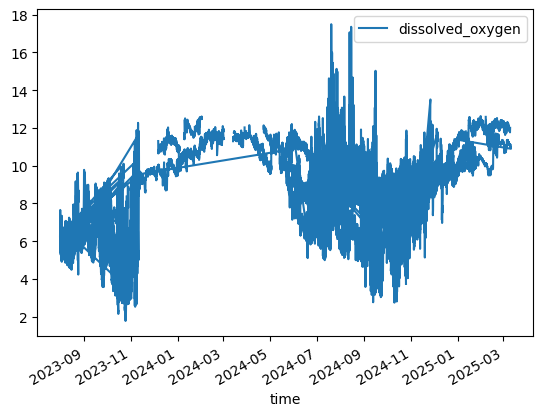

In [127]:
coop_fleet.plot(x='time',y='dissolved_oxygen')

## Join CFRF/eMOLT and Study Fleet

In [34]:
full_fleet = pd.concat([study_fleet, coop_fleet], ignore_index=True)
full_fleet.dropna(subset=['id'], inplace=True)
full_fleet['id'] = full_fleet['id'].astype(int)
full_fleet

,time,temperature,id,geometry,centroid,data_source,dissolved_oxygen,salinity
0,2012-11-02 00:00:00,16.200000,15038,"POLYGON ((-71.58332 41.05842, -71.50009 41.060...",POINT (-71.54049 41.02785),StudyFleet,NaN,NaN
1,2012-11-02 00:00:00,16.000000,15038,"POLYGON ((-71.58332 41.05842, -71.50009 41.060...",POINT (-71.54049 41.02785),StudyFleet,NaN,NaN
2,2012-11-02 00:00:00,16.000000,15038,"POLYGON ((-71.58332 41.05842, -71.50009 41.060...",POINT (-71.54049 41.02785),StudyFleet,NaN,NaN
3,2012-11-02 00:00:00,16.200000,15038,"POLYGON ((-71.58332 41.05842, -71.50009 41.060...",POINT (-71.54049 41.02785),StudyFleet,NaN,NaN
4,2012-11-02 00:00:00,16.200000,15038,"POLYGON ((-71.58332 41.05842, -71.50009 41.060...",POINT (-71.54049 41.02785),StudyFleet,NaN,NaN
...,...,...,...,...,...,...,...,...
6501634,2024-12-15 18:58:18,10.841646,15039,"POLYGON ((-71.58085 40.99543, -71.49771 40.997...",POINT (-71.53807 40.96485),CFRF,NaN,32.883454
6501635,2024-12-15 21:05:47,10.771686,15213,"POLYGON ((-71.49771 40.99726, -71.41456 40.999...",POINT (-71.45496 40.96666),CFRF,NaN,32.867246
6501636,2024-12-15 21:46:10,10.929684,15213,"POLYGON ((-71.49771 40.99726, -71.41456 40.999...",POINT (-71.45496 40.96666),CFRF,NaN,32.832006
6501637,2024-12-16 17:30:09,11.527067,15735,"POLYGON ((-71.24823 41.0024, -71.16505 41.0039...",POINT (-71.20559 40.9717),CFRF,NaN,33.195553


In [53]:
# Check to see if there are any overlapping observations 
temp_df = full_fleet.copy()
temp_df['date'] = temp_df['time'].dt.date
duplicates = temp_df.groupby(['id', 'date']).filter(lambda x: x['data_source'].nunique() > 1)
grouped = duplicates.groupby(['id', 'date']).agg({'data_source': 'unique', 'temperature': ['mean', 'std','min','max','count'], 'salinity':['mean', 'std','min','max','count'],'dissolved_oxygen':['mean', 'std','min','max','count']})
# grouped['observation_count'] = duplicates.groupby(['geometry', 'date', 'data_source']).size().unstack(fill_value=0)
grouped.to_csv('overlapping_data.csv')
# Check for overlapping entries based on geometry, time, and different data_source values
# duplicates = temp_df.groupby(['id', 'date']).filter(lambda x: x['data_source'].nunique() > 1)
# duplicates

In [51]:
grouped.index.get_level_values('date').nunique()

578

/home/linus/Documents/repositories/fishbot/python/env/lib/python3.10/site-packages/matplotlib/collections.py:1121: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


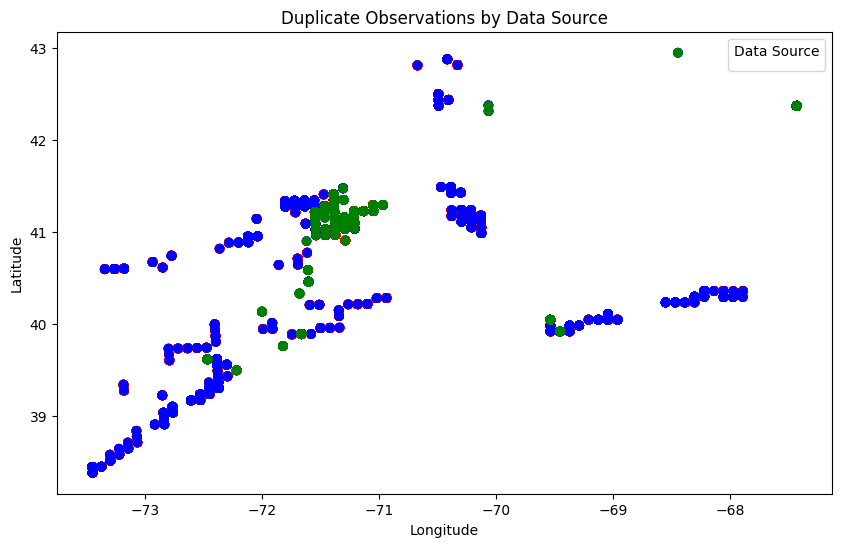

In [54]:
import matplotlib.pyplot as plt
duplicates['latitude'] = duplicates['centroid'].apply(lambda point: point.y)
duplicates['longitude'] = duplicates['centroid'].apply(lambda point: point.x)

# Define the color map
color_map = {'eMOLT': 'blue', 'StudyFleet': 'red', 'CFRF': 'green'}
duplicates['color'] = duplicates['data_source'].map(color_map)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(duplicates['longitude'], duplicates['latitude'], c=duplicates['color'])

# Create a legend
handles, labels = scatter.legend_elements("colors", alpha=0.6)
legend_labels = {v: k for k, v in color_map.items()}
ax.legend(handles, [legend_labels[label] for label in labels], title="Data Source")

# Add labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Duplicate Observations by Data Source')

plt.show()

In [8]:
import geopandas as gpd
from shapely.geometry import Point
# full_fleet['time'] = full_fleet['time'].dt.tz_localize(None)
full_fleet.dropna(subset=['id'], inplace=True)
full_fleet['date'] = full_fleet['time'].dt.date
full_fleet_aggregated = full_fleet.groupby(['date', 'centroid']).agg({'temperature': ['mean','min','max','std','count'],
                                                                      'dissolved_oxygen': ['mean','min','max','std','count'],
                                                                      'salinity': ['mean','min','max','std','count'],
                                                                      'data_source':'first',
                                                                      'id':'first',
                                                                      'geometry':'first'}).reset_index()
full_fleet_aggregated.columns = [
    '_'.join(filter(None, col)).strip() if col[1] else col[0]
    for col in full_fleet_aggregated.columns.to_flat_index()
]
full_fleet_aggregated['latitude'] = full_fleet_aggregated['centroid'].apply(lambda point: point.y)
full_fleet_aggregated['longitude'] = full_fleet_aggregated['centroid'].apply(lambda point: point.x)
full_fleet_aggregated = full_fleet_aggregated.drop(columns=['centroid'])
full_fleet_aggregated.rename(columns={'date': 'time',
                                      'temperature_mean':'temperature',
                                      'dissolved_oxygen_mean':'dissolved_oxygen',
                                      'salinity_mean':'salinity',
                                      'data_source_first':'data_source',
                                      'id_first':'grid_id',
                                      'geometry_first':'geometry'}, inplace=True)


# Read and process stat_area polygons
fid = 'data/statistical_areas/Statistical_Areas_2010_withNames.shp'
stat = gpd.read_file(fid)
stat.rename(columns={'Id': 'stat_area'}, inplace=True)

# Use a projected CRS for accurate centroid calculation
projected_crs = "EPSG:5070"  # Albers Equal Area Conic
stat = stat.to_crs(projected_crs)
stat['centroid'] = stat.geometry.centroid  # Compute centroids

# Keep both projected and WGS84 versions of centroids
stat['centroid_wgs84'] = stat['centroid'].to_crs("EPSG:4326")

# Function to find the nearest stat_area
def find_nearest_stat_area(row, stat_gdf):
    # Create a point in WGS84
    point_wgs84 = Point(row['longitude'], row['latitude'])
    
    # Convert the point to the projected CRS
    point_proj = gpd.GeoSeries([point_wgs84], crs="EPSG:4326").to_crs(projected_crs).geometry[0]
    
    # Compute distances using projected centroids
    distances = stat_gdf['centroid'].distance(point_proj)
    
    # Get the nearest stat_area
    nearest_idx = distances.idxmin()
    return stat_gdf.loc[nearest_idx, 'stat_area']

# Ensure full_fleet_aggregated is in EPSG:4326 and apply the function
full_fleet_aggregated['stat_area'] = full_fleet_aggregated.apply(
    find_nearest_stat_area, stat_gdf=stat, axis=1
)
full_fleet_aggregated#.columns = ['time', 'centroid', 'mean_temperature', 'min_temperature', 'max_temperature', 'std_temperature', 'count

,time,temperature,temperature_min,temperature_max,temperature_std,temperature_count,dissolved_oxygen,dissolved_oxygen_min,dissolved_oxygen_max,dissolved_oxygen_std,...,salinity_min,salinity_max,salinity_std,salinity_count,data_source,grid_id,geometry,latitude,longitude,stat_area
0,2006-09-20,7.350479,7.100000,10.100000,0.232478,313,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,StudyFleet,16924,"POLYGON ((-70.71412 42.83987, -70.6285 42.8411...",42.808998,-70.670463,514
1,2006-09-20,7.312670,7.100000,9.800000,0.215126,442,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,StudyFleet,16923,"POLYGON ((-70.71587 42.90288, -70.63016 42.904...",42.872008,-70.672162,514
2,2006-09-21,7.382723,7.100000,7.800000,0.105954,191,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,StudyFleet,16924,"POLYGON ((-70.71412 42.83987, -70.6285 42.8411...",42.808998,-70.670463,514
3,2006-09-21,7.350000,7.100000,9.500000,0.235267,272,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,StudyFleet,16923,"POLYGON ((-70.71587 42.90288, -70.63016 42.904...",42.872008,-70.672162,514
4,2006-09-22,7.285505,7.100000,9.300000,0.197109,545,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,StudyFleet,16924,"POLYGON ((-70.71412 42.83987, -70.6285 42.8411...",42.808998,-70.670463,514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126281,2025-03-15,4.137307,4.040534,4.179833,0.065034,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,eMOLT,17805,"POLYGON ((-70.27183 42.1522, -70.18712 42.1531...",42.121149,-70.228868,514
126282,2025-03-15,9.676852,9.670375,9.690000,0.007292,6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,eMOLT,17489,"POLYGON ((-70.39772 40.13302, -70.31558 40.133...",40.101988,-70.356024,537
126283,2025-03-15,4.875514,4.790833,4.922375,0.073475,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,eMOLT,18503,"POLYGON ((-69.93114 42.02939, -69.84658 42.030...",41.998200,-69.888422,521
126284,2025-03-15,4.729188,4.645500,4.885500,0.104526,5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,eMOLT,18502,"POLYGON ((-69.93206 42.09242, -69.84742 42.093...",42.061239,-69.889301,514


,time,temperature,temperature_min,temperature_max,temperature_std,temperature_count,dissolved_oxygen,dissolved_oxygen_min,dissolved_oxygen_max,dissolved_oxygen_std,...,salinity_min,salinity_max,salinity_std,salinity_count,data_source,grid_id,geometry,latitude,longitude,stat_area
110457,2023-12-28,9.492614,9.31,9.73,0.106293,176,9.755833,9.67,9.84,0.060499,...,NaN,NaN,NaN,0,StudyFleet,15381,"POLYGON ((-71.42849 41.37703, -71.34485 41.378...",41.346405,-71.385521,539
110460,2023-12-28,9.465243,9.27,9.63,0.082079,103,9.633333,9.58,9.72,0.038523,...,NaN,NaN,NaN,0,StudyFleet,15380,"POLYGON ((-71.43084 41.44003, -71.34712 41.441...",41.409404,-71.387825,539
110471,2023-12-29,9.468800,9.28,9.73,0.143574,75,9.590417,9.43,9.68,0.069249,...,NaN,NaN,NaN,0,StudyFleet,15381,"POLYGON ((-71.42849 41.37703, -71.34485 41.378...",41.346405,-71.385521,539


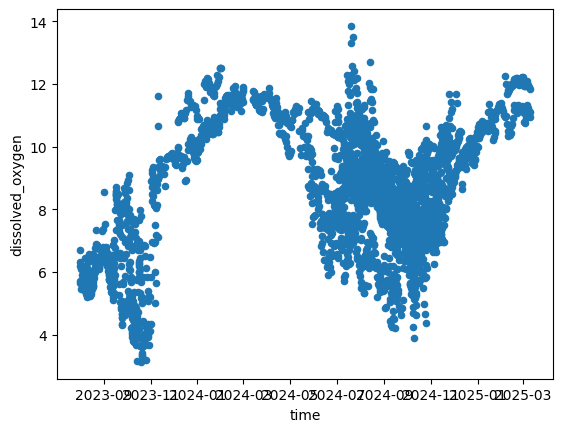

In [137]:
full_fleet_aggregated.plot.scatter(x='time', y='dissolved_oxygen')

full_fleet_aggregated[(~full_fleet_aggregated['dissolved_oxygen'].isna()) & (full_fleet_aggregated['data_source']=='StudyFleet')]#.data_source.value_counts()

<Axes: xlabel='time', ylabel='dissolved_oxygen'>

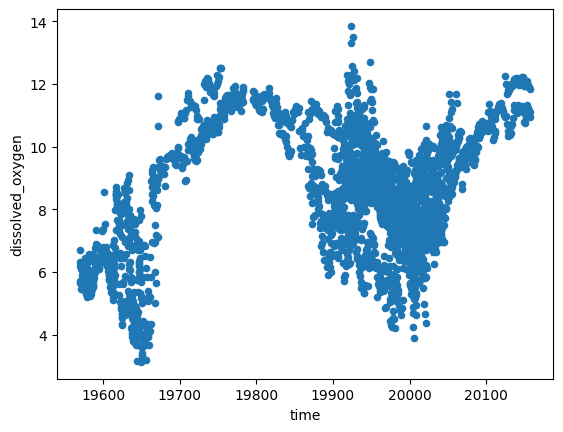

In [156]:
df_out = df_out[(df_out['depth']<900) & (df_out['depth']>1)]
df_out = df_out[(df_out['temperature']>0) & (df_out['temperature']<27)]
df_out[(df_out['depth']<900) & (df_out['depth']>1)].plot.scatter(x='time', y='dissolved_oxygen')


In [157]:
from datetime import datetime, timedelta
import os

df_out = full_fleet_aggregated.copy()
df_out.drop(columns=['geometry'], inplace=True)
def find_closest_depth(df) -> pd.DataFrame:
    '''Find the closest depth value from the bathymetry file'''
    fid = 'data/bathymetry/gebco_2024_n46.0_s36.0_w-76.0_e-64.0.nc'
    ds = xr.open_dataset(fid)
    # grouped = df.groupby('tow_id').agg({'latitude': 'first', 'longitude': 'first'}).reset_index()
    # Initialize an empty list to store depth values
    depths = ds.sel(
        lat=xr.DataArray(df['latitude'], dims='z'),
        lon=xr.DataArray(df['longitude'], dims='z'),
        method='nearest'
    )['elevation'].values

    # Add inferred depth as a new column, converting to absolute values
    df['depth'] = abs(depths).astype(int)
    return df

find_closest_depth(df_out)

# find_stat_area(df_out)
df_out['time'] = pd.to_datetime(df_out['time'])
# Define the epoch
epoch = datetime(1970, 1, 1)

# Convert time to days since epoch
df_out['time'] = (df_out['time'] - epoch).dt.days

# Do some filtering on the data for gross ranges
df_out = df_out[(df_out['depth']<900) & (df_out['depth']>1)]
df_out = df_out[(df_out['temperature']>0) & (df_out['temperature']<27)]


import xarray as xr
import pandas as pd
from datetime import datetime

grouped = df_out.groupby("time")

def set_variable_attrs(var_name):
    attrs = {
        "temperature": {
            "units": "degrees_Celsius",
            "standard_name": "sea_water_temperature",
            "long_name": "daily_mean_bottom_temperature",
            "comment": "Daily average bottom temperature"
        },
        "temperature_std": {
            "units": "degrees_Celsius",
            "long_name": "temperature_standard_deviation",
            "comment": "Daily standard deviation of bottom temperatures"
        },
        "temperature_min": {
            "units": "degrees_Celsius",
            "long_name": "temperature_minimum",
            "comment": "Daily minimum bottom temperature"
        },
        "temperature_max": {
            "units": "degrees_Celsius",
            "long_name": "temperature_maximum",
            "comment": "Daily maximum bottom temperature"
        },
        "temperature_count": {
            "units": "",
            "long_name": "temperature_observation_count",
            "comment": "Number of observations contributing to the daily average temperature"
        },
        "dissolved_oxygen": {
            "units": "miligrams_per_liter",
            "long_name": "daily_mean_bottom_dissolved_oxygen",
            "comment": "Daily average of bottom dissolved oxygen"
        },
        "dissolved_oxygen_std": {
            "units": "miligrams_per_liter",
            "long_name": "dissolved_oxygen_standard_deviation",
            "comment": "Daily standard deviation of bottom dissolved oxygen observations"
        },
        "dissolved_oxygen_min": {
            "units": "miligrams_per_liter",
            "long_name": "dissolved_oxygen_minimum",
            "comment": "Daily minimum bottom dissolved oxygen"
        },
        "dissolved_oxygen_max": {
            "units": "miligrams_per_liter",
            "long_name": "dissolved_oxygen_maximum",
            "comment": "Daily maximum bottom dissolved oxygen"
        },
        "dissolved_oxygen_count": {
            "units": "",
            "long_name": "dissolved_oxygen_observation_count",
            "comment": "Number of observations contributing to the daily average dissolved oxygen"
        },
        "salinity": {
            "units": "g/kg",
            "long_name": "daily_mean_bottom_salinity",
            "comment": "Daily average bottom salinity"
        },
        "salinity_std": {
            "units": "g/kg",
            "long_name": "salinity_standard_deviation",
            "comment": "Daily standard deviation of bottom salinities"
        },
        "salinity_min": {
            "units": "g/kg",
            "long_name": "salinity_minimum",
            "comment": "Daily minimum bottom salinity"
        },
        "salinity_max": {
            "units": "g/kg",
            "long_name": "salinity_maximum",
            "comment": "Daily maximum bottom salinity"
        },
        "salinity_count": {
            "units": "",
            "long_name": "salinity_observation_count",
            "comment": "Number of observations contributing to the daily average salinity"
        },
        "latitude": {
            "units": "degrees_north",
            "standard_name": "latitude",
            "axis": "Y",
            "comment": "Standardized centroid from predefined 7km grid of US Northeast"
        },
        "longitude": {
            "units": "degrees_east",
            "standard_name": "longitude",
            "axis": "X",
            "comment": "Standardized centroid from predefined 7km grid of US Northeast"
        },
        "time": {
            "standard_name": "time",
            "axis": "T",
            "units": "days since 1970-01-01T00:00:00 UTC",
            "comment": "Time in days since Unix epoch (UTC)"
        },
        "depth": {
            "units": "meters",
            "standard_name": "depth",
            "long_name": "inferred_depth",
            "comment": "Depth inferred from GEBCO bathymetry data"
        },
        "stat_area": {
            "units": "",
            "long_name": "NEFSC_statistical_area",
            "comment": "Statistical area used for fisheries management"
        },
        "data_source": {
            "units": "",
            "long_name": "data_source",
            "comment": "Source of the data"
        },
        "grid_id": {
            "units": "",
            "long_name": "grid_cell_identifier",
            "comment": "Identifier of the grid cell from the predefined 7km grid of US Northeast"
        }
    }

    return attrs.get(var_name, {})

for day, group in grouped:

    ds = xr.Dataset(
        {
            # Ensure all variables are indexed by both 'time' and 'point', with time length 1
            var: ("time", group[var].values) 
            for var in group.columns if var not in ["time", "latitude", "longitude"]
        },
        coords={
            "time": ("time", [day] * len(group)),  # Time as a single value for each day (length 1)
            "latitude": ("time", group["latitude"].values),  # Latitude for each point on that day
            "longitude": ("time", group["longitude"].values),  # Longitude for each point on that day
        },
    )
    ds.encoding["unlimited_dims"] = {"time"}

    for var in ds.data_vars:
        ds[var].attrs = set_variable_attrs(var)
    
    for coord in ds.coords:
        ds[coord].attrs = set_variable_attrs(coord)

    # Assign global metadata
    ds.attrs["title"] = f"Fishing Industry Shared Bottom Oceanographic Timeseries"
    ds.attrs["description"] = "Gridded daily observations of bottom temperature and related metrics."
    ds.attrs["institution"] = "NOAA NEFSC | CFRF"

    ds["temperature"] = ds["temperature"].astype("float32")
    ds["temperature_std"] = ds["temperature_std"].astype("float32")
    ds["temperature_min"] = ds["temperature_min"].astype("float32")
    ds["temperature_max"] = ds["temperature_max"].astype("float32")
    ds["temperature_count"] = ds["temperature_count"].astype("uint32")


    ds["dissolved_oxygen"] = ds["dissolved_oxygen"].astype("float32")
    ds["dissolved_oxygen_std"] = ds["dissolved_oxygen_std"].astype("float32")
    ds["dissolved_oxygen_min"] = ds["dissolved_oxygen_min"].astype("float32")
    ds["dissolved_oxygen_max"] = ds["dissolved_oxygen_max"].astype("float32")
    ds["dissolved_oxygen_count"] = ds["dissolved_oxygen_count"].astype("uint32")


    ds["salinity"] = ds["salinity"].astype("float32")
    ds["salinity_std"] = ds["salinity_std"].astype("float32")
    ds["salinity_min"] = ds["salinity_min"].astype("float32")
    ds["salinity_max"] = ds["salinity_max"].astype("float32")
    ds["salinity_count"] = ds["salinity_count"].astype("uint32")
    ds["depth"] = ds["depth"].astype("uint32")
    ds["latitude"] = ds["latitude"].astype("float32")
    ds["longitude"] = ds["longitude"].astype("float32")
    ds["time"] = ds["time"].astype("uint32")
    ds["stat_area"] = ds["stat_area"].astype("uint32")
    ds["grid_id"] = ds["grid_id"].astype("uint32")
    ds["data_source"] = ds["data_source"].astype("S32")
    
    date = datetime(1970, 1, 1) + timedelta(days=day)

    # Extract year and month
    year = date.year
    month = date.month
    
    # Save to NetCDF file
    output_path = "data/nc_out_full"
    directory = f"{output_path}/{year}/{month}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = f"{directory}/fishbot_{day}_v1.1.nc"
    # filename = f"data/nc_out_full/{year}/{month}/botgrid_{day}.nc"
    ds.to_netcdf(filename)
    # print(f"Saved: {filename}")

In [116]:
ds

<xarray.Dataset> Size: 116B
Dimensions:                 (time: 1)
Coordinates:
  * time                    (time) uint32 4B 20163
    latitude                (time) float32 4B 40.04
    longitude               (time) float32 4B -70.27
Data variables: (12/19)
    temperature             (time) float32 4B 9.799
    temperature_min         (time) float32 4B 9.765
    temperature_max         (time) float32 4B 9.832
    temperature_std         (time) float32 4B 0.02186
    temperature_count       (time) uint32 4B 90
    dissolved_oxygen        (time) float32 4B nan
    ...                      ...
    salinity_std            (time) float32 4B nan
    salinity_count          (time) uint32 4B 0
    data_source             (time) |S32 32B b'eMOLT'
    grid_id                 (time) uint32 4B 17664
    stat_area               (time) uint32 4B 537
    depth                   (time) uint32 4B 199
Attributes:
    title:        Fishing Industry Shared Bottom Oceanographic Timeseries
    description:  Gridded daily observations of bottom temperature and relate...
    institution:  NOAA NEFSC | CFRF

# Archive example data

In [47]:
import pandas as pd

test_archive = pd.DataFrame()
test_archive['file_url'] = ['https://botgrid.s3.us-east-1.amazonaws.com/archive/fishbot_archive_example.nc']
test_archive['archive_date'] = pd.to_datetime(['2025-02-11 00:00:00'])
test_archive['version'] = ['1.0']
test_archive['reload_type'] = ['full']
test_archive['doi'] = ['https://doi.org/10.5281/zenodo.1234567']
test_archive.to_csv('fishbot_archive_example.csv', index=False)


# Explore access erddap

In [ ]:
import pandas as pd
from erddapy import ERDDAP
import xarray as xr
def get_emolt_data(start_time, end_time='2023-12-31T23:59:59Z') -> xr.Dataset:
    # logger.info('Getting data from eMOLT ERDDAP server...')
    print
    server = 'https://erddap.emolt.net/erddap/'
    all_data = []
    try:
        # Split time range into monthly intervals
        date_range = pd.date_range(start=start_time, end=end_time, freq='M')
        date_range = date_range.union([pd.to_datetime(start_time), pd.to_datetime(end_time)]) # Ensure exact start and end are included

        for start, end in zip(date_range[:-1], date_range[1:]):
            e = ERDDAP(
                server=server,
                protocol="tabledap",
                response="nc",
            )
            e.dataset_id = 'eMOLT_RT_QAQC'
            e.constraints = {
                'time>=': start.strftime('%Y-%m-%dT%H:%M:%SZ'),
                'time<=': end.strftime('%Y-%m-%dT%H:%M:%SZ'),
                'segment_type=': 'Fishing',
                'latitude>=': 41,
                'latitude<=': 41.5,
                'longitude>=': -72,
                'longitude<=': -70
            }
            e.requests_kwargs = {'timeout': 600}  # Extended timeout

            # Fetch data for this interval and append it to the list
            try:
                data = e.to_xarray()
                all_data.append(data)
                # logger.info('Data for period %s to %s retrieved successfully.', start, end)
            except Exception as e:
                pass
                # logger.error('Error retrieving data for period %s to %s: %s', start, end, e)

        # Concatenate all chunks
        if all_data:
            combined_data = xr.concat(all_data, dim='time')
            # logger.info('All data successfully combined.')
            return combined_data

    except Exception as e:
        pass
        # logger.error('Error connecting to ERDDAP server: %s', e)

ds = get_emolt_data('2023-01-01T00:00:00Z', '2023-12-31T23:59:59Z')
ds

/tmp/ipykernel_128304/2037064365.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=start_time, end=end_time, freq='M')


In [ ]:
import xarray as xr

# Specify the path to your NetCDF file
file_path = 'fishbot.nc'

# Open the NetCDF file
ds = xr.open_dataset(file_path)

# Display the dataset
ds

<xarray.Dataset> Size: 15MB
Dimensions:                 (row: 125249)
Coordinates:
    time                    (row) datetime64[ns] 1MB ...
    depth                   (row) float64 1MB ...
    latitude                (row) float32 501kB ...
    longitude               (row) float32 501kB ...
Dimensions without coordinates: row
Data variables: (12/18)
    temperature             (row) float32 501kB ...
    temperature_min         (row) float32 501kB ...
    temperature_max         (row) float32 501kB ...
    temperature_std         (row) float32 501kB ...
    temperature_count       (row) float64 1MB ...
    dissolved_oxygen        (row) float32 501kB ...
    ...                      ...
    salinity_max            (row) float32 501kB ...
    salinity_std            (row) float32 501kB ...
    salinity_count          (row) float64 1MB ...
    data_source             (row) object 1MB ...
    grid_id                 (row) float64 1MB ...
    stat_area               (row) float64 1MB ...
Attributes: (12/35)
    cdm_data_type:                 Point
    Conventions:                   COARDS, CF-1.10, ACDD-1.3
    creator_name:                  NOAA | CFRF
    creator_type:                  institution
    creator_url:                   https://github.com/CommercialFisheriesRese...
    description:                   Gridded daily observations of bottom tempe...
    ...                            ...
    subsetVariables:               stat_area, data_source
    summary:                       Fishing Industry Shared Bottom Oceanograph...
    time_coverage_end:             2025-03-16T00:00:00Z
    time_coverage_start:           2006-09-20T00:00:00Z
    title:                         Fishing Industry Shared Bottom Oceanograph...
    Westernmost_Easting:           -76.21344

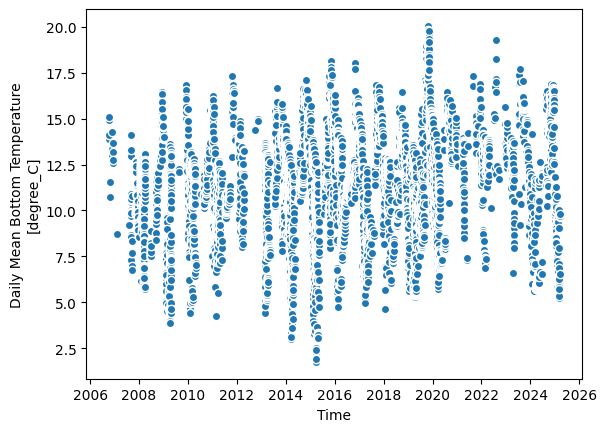

In [4]:
ds_filtered = ds.where(ds['stat_area'] == 537, drop=True)
ds_filtered.plot.scatter(x='time', y='temperature')